Use `load_boston` to load the Boston Housing Dataset.
You must create a Linear Regression model fitted to this data to predict house prices.

- Check the data for nulls
- Explore the data, distributions, correlations.
- Take that into mind when choosing the features for your model.
- Watch out for colinearity.
- Split your data into train and test. [Check out how!](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- Measure the goodness of your fit! $R^2$, $RMSE$, etc.
- Try to make it better.
- Do your own research. Checkout both sklearn and statsmodels, get a feel of both.
- Have fun.


In [24]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [2]:
X,y = load_boston(return_X_y=True)
X = pd.DataFrame(X)
X.columns = load_boston()['feature_names']
y = pd.DataFrame(y)

In [3]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
altogether = X.join(y)
altogether.rename(columns={0: 'MEDV'}, inplace=True)
altogether.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


From the describe function we can underline that the mean number of rooms per house is more than 6, the mean proportion of owner-occupied units built prior to 1940 is higher than 68, the mean distance to the employment centres is around 4 miles, the mean property-tax rate is around 408K, or the mean value of owner-occupied homes in $1000's is 22.5.

Let's see the correlation between the mean property-tax rate and the rest of the columns.

In [5]:
pd.DataFrame(altogether.corr()['MEDV']).drop('MEDV').sort_values(by='MEDV', ascending=False)

,MEDV
RM,0.695360
ZN,0.360445
B,0.333461
DIS,0.249929
CHAS,0.175260
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321
TAX,-0.468536


As we can see, the strongest correlation with the house prices is given by the LSTAT column, which is the % lower status of the population. This is a negative correlation, which means the higher the % of lower status of the population, the lower the price of the houses.

More examples about negative correlations are the PTRATIO (pupil-teacher ratio by town), the INDUS (proportion of non-retail business acres per town), TAX (full-value property-tax rate per $10,000), NOX (nitric oxides concentration) CRIM (per capita crime rate by town), RAD (index of accessibility to radial highways) or AGE (proportion of owner-occupied units built prior to 1940).

This is followed by RM, which is the average number of rooms per dwelling. It is a positive correlation, which means the higher the average number of rooms, the higher will be the price.

Another example on positive correlation is ZN (proportion of residential land zoned for lots over 25,000 sq.ft.).

Let's perform a first multiple regression model, using the ordinary least squares one, in order to check which of the independent variables are related to our Y variable (are statistically significant, which is our alternative hypothesis) and which ones are not related to it (statistically insignificant, which is our null hypothesis).

Said that, I will remove those variables where the p-values is greater than an alpha of 0.05.

In [10]:
X_mod = sm.add_constant(X)

mod = sm.OLS(y, X_mod)
res = mod.fit()

p_values = res.summary2().tables[1]
r_squared = res.summary2().tables[0].iloc[6,1]
print(f'The OLS Model gives a R-squared of {r_squared}')
p_values[p_values['P>|t|'] > 0.05]

The OLS Model gives a R-squared of 0.741


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
INDUS,0.020559,0.061496,0.334310,0.738288,-0.100268,0.141385
AGE,0.000692,0.013210,0.052402,0.958229,-0.025262,0.026647


As the results shows, this first model gives us an $R^2$ of 0.741, which is a really good value. 

Refering to our hypothesis, we can see that the null one is only accepted for the variables INDUS and AGE, meaning that those three are statistically insignificant for our model, and we can remove them.

Let's try a new test without those variables.

In [11]:
X_new = sm.add_constant(X.drop(['INDUS', 'AGE'], axis=1))

mod = sm.OLS(y, X_new)
fii = mod.fit()

sumary = fii.summary()
sumary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Thu, 26 Nov 2020   Prob (F-statistic):          5.54e-137
Time:                        10:04:06   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.3411      5.067      7.171      0.000      26.385      46.298
CRIM          -0.1084      0.033     -3.307      0.001      -0.173      -0.044
ZN             0.0458      0.014      3.390      0.001       0.019       0.072
CHAS           2.7187      0.854      3.183      0.002       1.040       4.397
NOX          -17.3760      3.535     -4.915      0.000     -24.322     -10.430
RM             3.8016      0.406      9.356      0.000       3.003       4.600
DIS           -1.4927      0.186     -8.037      0.000      -1.858      -1.128
RAD            0.2996      0.063      4.726      0.000       0.175       0.424
TAX           -0.0118      0.003     -3.493      0.001      -0.018      -0.005
PTRATIO       -0.9465      0.129     -7.334      0.000      -1.200      -0.693
B              0.0093      0.003      3.475      0.001       0.004       0.015
LSTAT         -0.5226      0.047    -11.019      0.000      -0.616      -0.429
==============================================================================
Omnibus:                      178.430   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.785
Skew:                           1.523   Prob(JB):                    8.60e-172
Kurtosis:                       8.300   Cond. No.                     1.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As the results show, our $R^2$ mantains its value, and all our independent variables are smaller than 0.05. Let's now try the accuracy of our model predictions splitting our observations in train and test groups, so we can check.

In [12]:
intercept, coeff = fii.params[0], fii.params.drop('const')

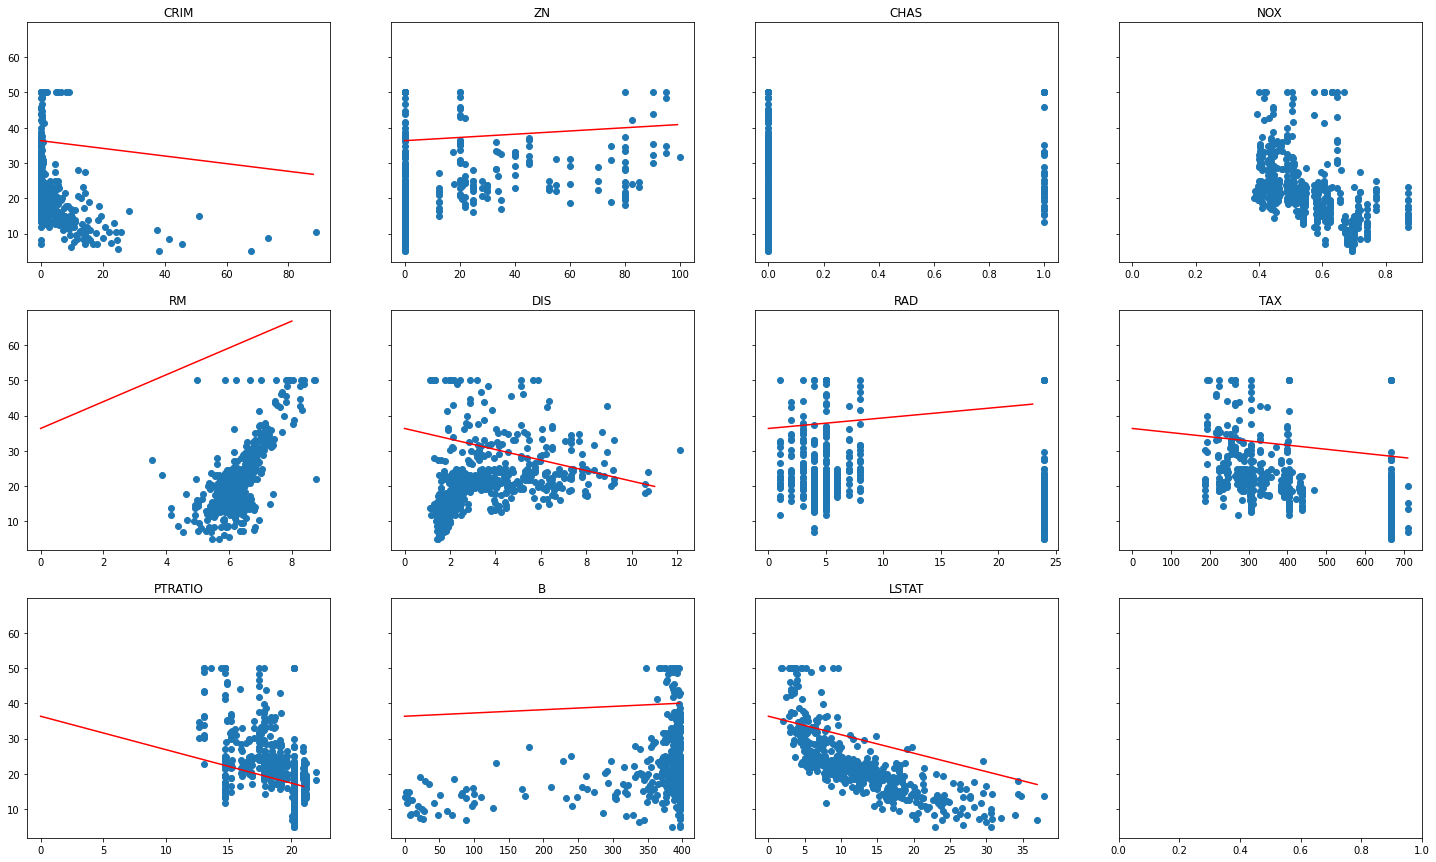

In [13]:
def line(x, coeff, interc):
    return x * coeff + interc

fig, axs = plt.subplots(nrows=3, ncols=4, sharey=True, figsize=(25,15))
ind = 0
for colname, coldata in X_new.iloc[:,1:].iteritems():
    x_line = range(round(coldata.max()))
    if ind < 4:
        axs[0,ind].scatter(x=coldata, y=y)
        axs[0,ind].plot(x_line, line(x_line, coeff[colname], intercept), c='r')
        axs[0,ind].set_title(f"{colname}")
    elif ind >= 4 and ind < 8:
        axs[1,ind-4].scatter(x=coldata, y=y)
        axs[1,ind-4].plot(x_line, line(x_line, coeff[colname], intercept), c='r')
        axs[1,ind-4].set_title(f"{colname}")
    else:
        axs[2,ind-8].scatter(x=coldata, y=y)
        axs[2,ind-8].plot(x_line, line(x_line, coeff[colname], intercept), c='r')
        axs[2,ind-8].set_title(f"{colname}")
    ind += 1
    

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [15]:
model_tt = sm.OLS(y_train, X_train)
results = model_tt.fit()

predictions = results.predict(X_test)

In [16]:
r_squared = results.summary2().tables[0].iloc[6,1]
r_squared

'0.738'

In [17]:
rmse(predictions, y_test[0])

4.512999333293969

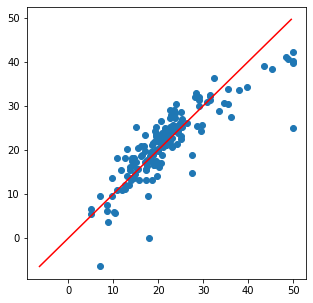

In [34]:
plt.subplots(figsize=(5,5))
plt.scatter(y_test[0], predictions)
x = np.arange(np.concatenate([predictions, y_test[0].to_list()]).min(), np.concatenate([predictions,y_test[0].to_list()]).max())
plt.plot(x,x,c='r');

### Further resources

- [The internet is your friend](https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c)
- [Scikit-Learn](https://scikit-learn.org)
- [Statsmodels](https://statsmodels.org)